In [ ]:
%pip install tensorflow

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os
import zipfile


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/University/Year_3/DNN/train.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [5]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [6]:
## loading training set
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/tmp/train/',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 70295 files belonging to 38 classes.


In [7]:
## loading validation dataset
validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
   '/tmp/valid',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 17572 files belonging to 38 classes.


In [16]:
test_ds =  tf.keras.preprocessing.image_dataset_from_directory(
   '/tmp/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 33 files belonging to 1 classes.


In [ ]:
df = []
for root, dirs, files in os.walk('/tmp/train/'):
    df.append([root[11:], len(files)])

df.pop(0)
print(df)
df_final = pd.DataFrame (df, columns = ['Disease', 'Number of Images'])
df_final.head()

#Creating Pandas for Plotting




[['Peach___healthy', 1728], ['Strawberry___healthy', 1824], ['Tomato___Early_blight', 1920], ['Apple___Cedar_apple_rust', 1760], ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 1642], ['Cherry_(including_sour)___Powdery_mildew', 1683], ['Squash___Powdery_mildew', 1736], ['Grape___Esca_(Black_Measles)', 1920], ['Potato___Late_blight', 1939], ['Apple___Apple_scab', 2016], ['Tomato___healthy', 1926], ['Pepper,_bell___Bacterial_spot', 1913], ['Tomato___Tomato_Yellow_Leaf_Curl_Virus', 1961], ['Apple___Black_rot', 1987], ['Apple___healthy', 2008], ['Soybean___healthy', 2022], ['Tomato___Late_blight', 1851], ['Peach___Bacterial_spot', 1838], ['Potato___Early_blight', 1939], ['Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 1722], ['Tomato___Bacterial_spot', 1702], ['Grape___healthy', 1692], ['Strawberry___Leaf_scorch', 1774], ['Tomato___Spider_mites Two-spotted_spider_mite', 1741], ['Blueberry___healthy', 1816], ['Corn_(maize)___Northern_Leaf_Blight', 1908], ['Orange___Haunglongbing_(Citr

,Disease,Number of Images
0,Peach___healthy,1728
1,Strawberry___healthy,1824
2,Tomato___Early_blight,1920
3,Apple___Cedar_apple_rust,1760
4,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,1642


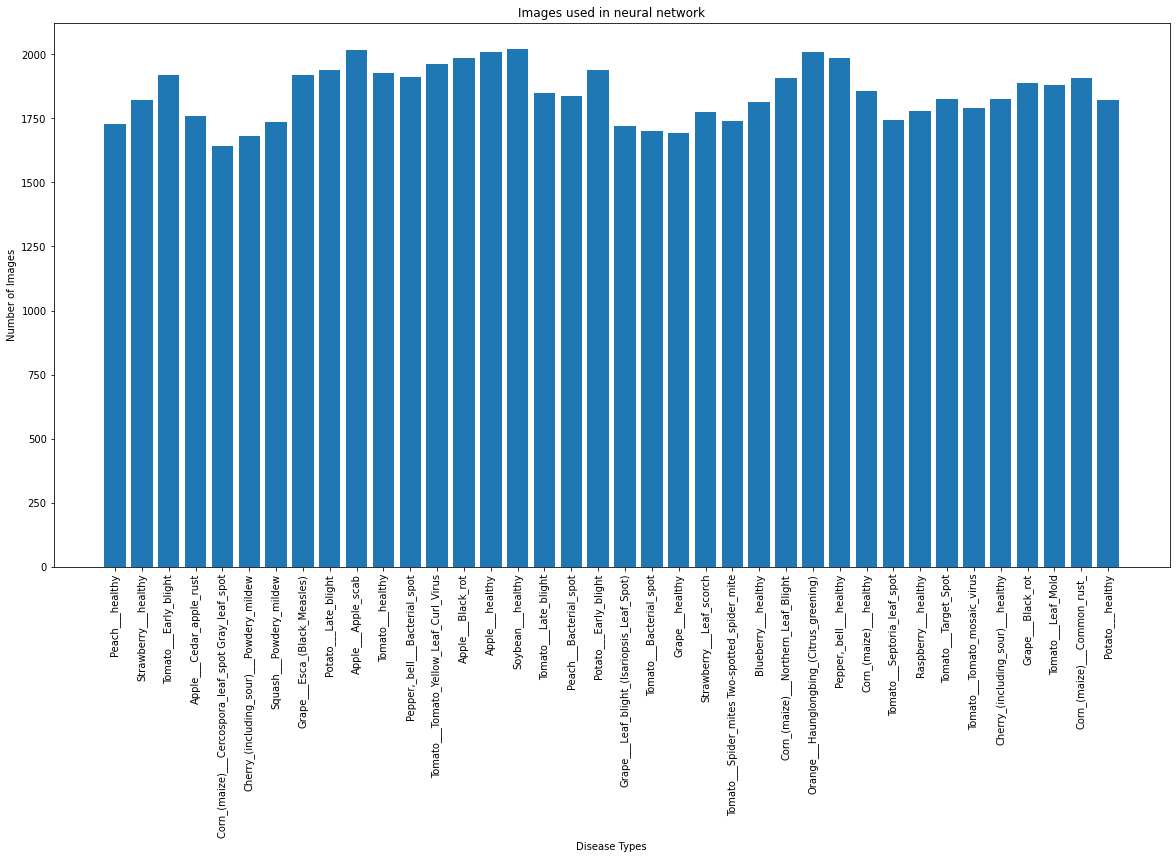

In [ ]:
plt.figure(figsize=(20, 10))

plt.bar(df_final["Disease"], df_final["Number of Images"])
plt.xlabel("Disease Types")
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.title("Images used in neural network")

plt.show()
#Neural Netwwork Graph

In [17]:
class_names = training_ds.class_names

DEFINING AUTO-ENCODER CNN

In [ ]:
from tensorflow.keras.models import Model
input = layers.Input(shape=(250, 250, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(len(class_names), activation= 'softmax')(x)


# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="softmax", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(len(class_names), activation= 'softmax')(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
autoencoder.summary()




In [ ]:
autoencoder.fit(training_ds,validation_data= validation_ds,epochs = 5)

In [ ]:
print(autoencoder.predict(test_ds))

In [ ]:
#Plotting Using AutoEncoder
AccuracyVector = []
plt.figure(figsize=(40, 40))
for images, labels in validation_ds.take(1):
    predictions = autoencoder.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(3):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(autoencoder, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

DEFINING SEQUENTIAL CNN

In [9]:
## Defining Cnn
MyCnn = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

In [10]:
MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
## lets train our CNN
retVal = MyCnn.fit(training_ds,validation_data= validation_ds,epochs = 5)

In [ ]:
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

In [ ]:
AccuracyVector = []
plt.figure(figsize=(30, 40))
for images, labels in validation_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(8):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [ ]:
plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(MyCnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
MyCnn.save('model.h5')